# Deep Learning a Stochastic Volatility Surface

Author: Sebastien Gurrieri, sebgur@gmail.com

The purpose of this notebook is to provide a simple demo of the training of DNNs to fit implied volatility surfaces within [SDevPy](https://pypi.org/project/sdevpy/). This library was recently released and is designed to simplify the process of generating datasets, training models and testing them, currently applied to the calibration of interest rate implied volatility surfaces.

The principles at play here have been introduced and illustrated in a number of references. [[Hernandez 2016]](https://www.risk.net/media/download/952386/download) train a network to learn the model parameters as functions of the market prices for the Hull-White model ("inverse map"). [[Horvath et al. 2019]](https://arxiv.org/abs/1901.09647) prefer to learn the prices as functions of the model parameters ("direct map"), and apply this strategy to a number of stochastic volatility surfaces, including the rough Bergomi model. [McGhee 2018](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3288882) uses a similar approach to learn the SABR model. [Kienitz et al. 2021](https://www.youtube.com/watch?v=48QpXv1VTl8) have extended these ideas to other stochastic volatility surfaces such as Free-Boundary SABR, ZABR and Heston.

The overarching idea behind these references is that the neural network could be used as a replacement for a traditional valuation method to price vanilla options (direct map) or possibly to infer the model parameters from option prices (inverse map). Traditional methods such as analytical expressions may not be available for certain complex models. For these models, only PDE or Monte-Carlo simulations would allow us to calculate prices for the purpose of model calibration, but optimization on PDE or MC is exceedingly costly. The neural network can then be used to off-load the calculation time to the training phase, while the on-line calibration can be performed on the trained network very quickly.

Our purpose in [SDevPy](https://pypi.org/project/sdevpy/) is to create a python framework to easily develop those ideas and share datasets as well as trained networks. Here we start with the direct map, in a very similar fashion to the work by [Kienitz et al. 2021](https://www.youtube.com/watch?v=48QpXv1VTl8) and [McGhee 2018](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3288882). The library has a number of built-in methods to generate sample datasets and train the networks for the chosen models, which include SABR (Hagan), No-Arbitrage SABR, Free-Boundary SABR, ZABR and Heston. It can also easily download sample datasets and use pre-trained models from our [github repository](https://github.com/sebgur/SDev.Python) and [Kaggle for larger datasets](https://www.kaggle.com/sebastiengurrieri/datasets).

Generation of samples has been covered in a [previous notebook](https://colab.research.google.com/drive/1-0vRa31xcMwe8iE_U7cZATiTis17oFxL#scrollTo=nbUPFzrDMbUA). In the work here, the user may choose to:
* train a network from scratch (and test it on provided samples) or
* download a pre-trained network and test it on provided samples.

This is the preliminary step towards other goals we have in mind. Namely, we think that it would be valuable to develop the inverse map for these models but also bring this work to more "complex" models such as stochastic local vol multi-factor Cheyette, and we hope that the present framework can pave the way in this direction. The saved models have been trained with various amounts of efforts and on various amounts of data, ranging from 500k to 2 million samples. As a proof of concept we spent more time on the Hagan SABR model for which it was obviously easier to generate millions of samples, but since the shapes to learn are similar in other models, we think that, provided the sample datasets are clean, similar accuracies should be reachable on the other models. Obtaining clean datasets is therefore key. We use Monte-Carlo simulation for ease of implementation, but this leads to very slow generation and noisy data. PDEs would surely offer cleaner data for faster runtime. See [Kienitz et al. 2021](https://www.youtube.com/watch?v=48QpXv1VTl8) for materials on SABR-like PDEs.

Note that the [SDevPy](https://pypi.org/project/sdevpy/) library contains a number of utilities that can prove useful in different financial applications, such as Black/Bachelier formulas, Monte-Carlo simulations of stochastic volatility models, and tools to wrap standard machine learning methods.

In [17]:
# Install SDevPy
!pip install sdevpy --upgrade

In [12]:
# Import relevant modules
import os
from datetime import datetime
import numpy as np
from platform import python_version
import zipfile as zf
import tensorflow as tf
import matplotlib.pyplot as plt

import sdevpy as sd
from sdevpy.tools import filemanager
from sdevpy.tools.timer import Stopwatch
from sdevpy.maths.metrics import bps_rmse, tf_bps_rmse
from sdevpy.volsurfacegen import stovolfactory
from sdevpy.machinelearning import datasets
from sdevpy.machinelearning.topology import compose_model
from sdevpy.machinelearning.learningmodel import LearningModel, load_learning_model
from sdevpy.machinelearning.learningschedules import FlooredExponentialDecay
from sdevpy.machinelearning.callbacks import RefCallback
from sdevpy.projects.stovol import stovolplot as xplt


print("Python version: " + python_version())
print("NumPy version: " + np.__version__)
print("Tensorflow version: " + tf.__version__)
print("SDevPy version: " + sd.__version__)

Python version: 3.10.12
NumPy version: 1.22.4
Tensorflow version: 2.12.0
SDevPy version: 0.1.5


## 1) Set runtime configuration


In [14]:
# Global settings
MODEL_TYPE = "SABR"
# MODEL_TYPE = "McSABR"
# MODEL_TYPE = "FbSABR"
# MODEL_TYPE = "McZABR"
# MODEL_TYPE = "McHeston"
MODEL_ID = "SABR_3L_64n" # MODEL_TYPE # Pre-trained model ID, may differ from MODEL_TYPE
USE_TRAINED = True
DOWNLOAD_MODELS = True # Only used when USE_TRAINED is True
DOWNLOAD_DATASETS = True # Use when already created/downloaded
TRAIN = False
if USE_TRAINED is False and TRAIN is False:
    raise RuntimeError("When not using pre-trained models, a new model must be trained")

NUM_SAMPLES = 50 * 1000 # Number of samples to read from sample files
TRAIN_PERCENT = 0.90 # Proportion of dataset used for training (rest used for test)
EPOCHS = 100
BATCH_SIZE = 1000
# For comparison to reference values (accuracy of reference)
NUM_MC = 100 * 1000 # 100 * 1000
POINTS_PER_YEAR = 25 # 25
project_folder = os.path.join("/content/sdevpy", "stovol")

print(">> Set up runtime configuration")
print("> Chosen model: " + MODEL_TYPE)
if USE_TRAINED:
    print("> Pre-trained model ID: " + MODEL_ID)

filemanager.check_directory(project_folder)
print("> Project folder: " + project_folder)

dataset_folder = os.path.join(project_folder, "datasets")
data_folder = os.path.join(dataset_folder, MODEL_TYPE)
filemanager.check_directory(data_folder)
print("> Data folder: " + data_folder)
data_file = os.path.join(dataset_folder, MODEL_TYPE + "_data.tsv")
print("> Data file: " + data_file)

model_folder = os.path.join(project_folder, "models")
filemanager.check_directory(model_folder)
print("> Model folder: " + model_folder)

# Select the model
generator = stovolfactory.set_generator(MODEL_TYPE, num_mc=NUM_MC, points_per_year=POINTS_PER_YEAR)

>> Set up runtime configuration
> Chosen model: SABR
> Pre-trained model ID: SABR_3L_64n
> Project folder: /content/sdevpy/stovol
> Data folder: /content/sdevpy/stovol/datasets/SABR
> Data file: /content/sdevpy/stovol/datasets/SABR_data.tsv
> Model folder: /content/sdevpy/stovol/models


## 2) Prepare the datasets

Datasets need to be read even if we do not train, as we are then going to evaluate the performance of a trained model loaded from a saved state and applied to the dataset.


In [3]:
if USE_TRAINED and DOWNLOAD_MODELS:
    url = 'https://github.com/sebgur/SDev.Python/raw/main/models/stovol/models.zip'
    print("> Downloading and unzipping models from: " + url)
    filemanager.download_unzip(url, model_folder)

> Downloading and unzipping models from: https://github.com/sebgur/SDev.Python/raw/main/models/stovol/models.zip


In [4]:
if DOWNLOAD_DATASETS:
    url = 'https://github.com/sebgur/SDev.Python/raw/main/datasets/stovol/datasets.zip'
    print("> Downloading and unzipping datasets from: " + url)
    filemanager.download_unzip(url, dataset_folder)

> Downloading and unzipping datasets from: https://github.com/sebgur/SDev.Python/raw/main/datasets/stovol/datasets.zip


In [6]:
# Datasets are read and split into training and test sets. This split is only useful
# in case of training, but is always down for simplicity.
print(">> Preparing datasets")
# Retrieve data from dataset folder
print(f"> Requested {NUM_SAMPLES:,} samples")
datasets.retrieve_data(data_folder, NUM_SAMPLES, shuffle=True, export_file=data_file)
print("> Exporting dataset to file: " + data_file)

print("> Reading dataset from: " + data_file)
x_set, y_set, data_df = generator.retrieve_datasets(data_file, shuffle=True)
input_dim = x_set.shape[1]
output_dim = y_set.shape[1]
print("> Input dimension: " + str(input_dim))
print("> Output dimension: " + str(output_dim))
print("> Dataset extract")
print(data_df.head())
# Split into training and test sets
TRS = TRAIN_PERCENT * 100
print(f"> Splitting between training set ({TRS:.2f}%) and test set ({100 - TRS:.2f}%)")
x_train, y_train, x_test, y_test = datasets.prepare_sets(x_set, y_set, TRAIN_PERCENT)

>> Preparing datasets
> Requested 50,000 samples
> Exporting dataset to file: /content/sdevpy/stovol/datasets/SABR_data.tsv
> Reading dataset from: /content/sdevpy/stovol/datasets/SABR_data.tsv
> Input dimension: 7
> Output dimension: 1
> Dataset extract
             Ttm         K         F     LnVol      Beta        Nu       Rho  \
30433  23.792018 -0.011841 -0.005981  0.071664  0.881750  0.424720 -0.157301   
37332  16.193804 -0.006427  0.002202  0.324288  0.585983  0.162520 -0.325927   
3803   16.852812  0.004119 -0.006996  0.072437  0.473683  0.565815 -0.547003   
39993  32.763496 -0.029603  0.023523  0.366772  0.536924  0.738910  0.273880   
14006  25.156139 -0.029698  0.001541  0.486976  0.487578  0.300482  0.495706   

          Price      NVol  
30433  0.002830  0.002697  
37332  0.010615  0.009047  
3803   0.012283  0.002941  
39993  0.000397  0.005102  
14006  0.000302  0.003589  
> Splitting between training set (90.00%) and test set (10.00%)


## 3) Compose the learning model

If we load a pre-trained model (USE_TRAINED=True), we read its characteristics for display. However if we chose to start training a fresh new model, we need to specify its structure.

In [15]:
if USE_TRAINED:
    print(">> Loading pre-trained model")
    model_folder_name = os.path.join(model_folder, MODEL_ID)
    print("> Loading pre-trained model from: " + model_folder_name)
    model = load_learning_model(model_folder_name)
    keras_model = model.model
    HIDDEN_LAYERS = NUM_NEURONS = DROP_OUT = None
    topology = model.topology_
    if topology is not None:
        HIDDEN_LAYERS = topology['layers']
        NUM_NEURONS = topology['neurons']
        DROP_OUT = topology['dropout']
else:
    print(">> Composing new model")
    # Initialize the model
    HIDDEN_LAYERS = ['softplus', 'softplus', 'softplus']
    NUM_NEURONS = 64
    DROP_OUT = 0.0
    keras_model = compose_model(input_dim, output_dim, HIDDEN_LAYERS, NUM_NEURONS, DROP_OUT)
    topology = { 'layers': HIDDEN_LAYERS, 'neurons': NUM_NEURONS, 'dropout': DROP_OUT}

    model = LearningModel(keras_model)
    model.topology_ = topology

# Display topology
print(f"> Hidden layer structure: {HIDDEN_LAYERS}")
print(f"> Number of neurons per layer: {NUM_NEURONS}")
print(f"> Drop-out rate: {DROP_OUT:.2f}")

>> Loading pre-trained model
> Loading pre-trained model from: /content/sdevpy/stovol/models/SABR_3L_64n
> Hidden layer structure: ['softplus', 'softplus', 'softplus']
> Number of neurons per layer: 64
> Drop-out rate: 0.00


## 4) Training

If the user chose to train, training will start here by specifying the learning schedule in a custom class for which the learning rate starts at INIT_LR and decreases exponentially down to FINAL_LR. As a rule of thumb from trial and error, we find that for fresh training INIT_LR=1e-1 tends to produce good results, while for focusing accuracy of a pre-trained model, smaller learning rates around 1e-2 or 1e-3 are better.

We also implement a custom callback that periodically calculates the loss (RMSE) on the test set to watch for over-fitting.

At the end of the training, the model is saved under a new name. Note that we use our own wrapper (LearningModel) above the Keras model. It includes scalers and various additional functionalities for loading and saving.

In [9]:
if TRAIN:
    # Learning rate scheduler
    INIT_LR = 1.0e-2
    FINAL_LR = 1.0e-3
    DECAY = 0.97
    STEPS = 250
    lr_schedule = FlooredExponentialDecay(INIT_LR, FINAL_LR, DECAY, STEPS)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.optimizer_ = optimizer.get_config()
    print("> Optimizer settings")
    optim_fields = model.optimizer_
    for field, value in optim_fields.items():
        print("> ", field, ":", value)

    # Compile
    print("> Compile model")
    keras_model.compile(loss=tf_bps_rmse, optimizer=optimizer)

    # Callbacks
    EPOCH_SAMPLING = 5
    callback = RefCallback(x_test, y_test, bps_rmse, optimizer=optimizer,
                           epoch_sampling=EPOCH_SAMPLING)

    # Train the network
    print(">> Training ANN model")
    trn_timer = Stopwatch("Training")
    trn_timer.trigger()
    model.train(x_train, y_train, EPOCHS, BATCH_SIZE, callback)
    trn_timer.stop()
    trn_timer.print()

    # Save trained model to file
    now = datetime.now()
    dt_string = now.strftime("%Y%m%d-%H_%M_%S")
    model_folder_name = os.path.join(model_folder, MODEL_TYPE + "_" + dt_string)
    print("Saving model to: " + model_folder_name)
    model.save(model_folder_name)

> Optimizer settings
>  name : Adam
>  weight_decay : None
>  clipnorm : None
>  global_clipnorm : None
>  clipvalue : None
>  use_ema : False
>  ema_momentum : 0.99
>  ema_overwrite_frequency : None
>  jit_compile : False
>  is_legacy_optimizer : False
>  learning_rate : {'class_name': 'FlooredExponentialDecay', 'config': {'initial_lr': 0.01, 'final_lr': 0.001, 'decay': 0.97, 'decay_steps': 250}}
>  beta_1 : 0.9
>  beta_2 : 0.999
>  epsilon : 1e-07
>  amsgrad : False
> Compile model
>> Training ANN model
<><><><><><><><> TRAINING START <><><><><><><><>
Epochs: 100
Batch size: 1,000
Shuffle: True
Training set size: 45,000
<><><><><><><><><><><><><><><><>
Epoch 0/100
Loss: 7.42, LR: 0.009952, Test loss: 6.78
<><><><><><><><><><><><><><><><>
Epoch 5/100
Loss: 5.59, LR: 0.009710, Test loss: 6.97
<><><><><><><><><><><><><><><><>
Epoch 10/100
Loss: 4.77, LR: 0.009474, Test loss: 7.16
<><><><><><><><><><><><><><><><>
Epoch 15/100
Loss: 5.81, LR: 0.009245, Test loss: 6.93
<><><><><><><><><><>

## 5) Testing

The model, which may have simply been loaded or trained, is now evaluated on the training and test sets. We also use a specific point to display in charts the comparison between the model and the reference (on which it was trained, which may come from closed-form, PDE or MC). The chart comparison can be done on 3 possible variables (called TRANSFORM here): the prices, the Bachelier or Shifted Black-Scholes implied volatilities. Finally, if the model was trained here, we show the evolution of the training loss and learning schedule.

>> Analyse results
> RMSE(nvol) on training set: 3.19
> RMSE(nvol) on test set: 3.70
> Choosing a sample parameter set to display chart
> Calculating chart surface with reference model
> Calculating chart surface with trained model
> Ref-Mod RMSE(price): 0.30
Runtime(Reference surface calculation): 0.1s
Runtime(Model surface calculation): 0.1s


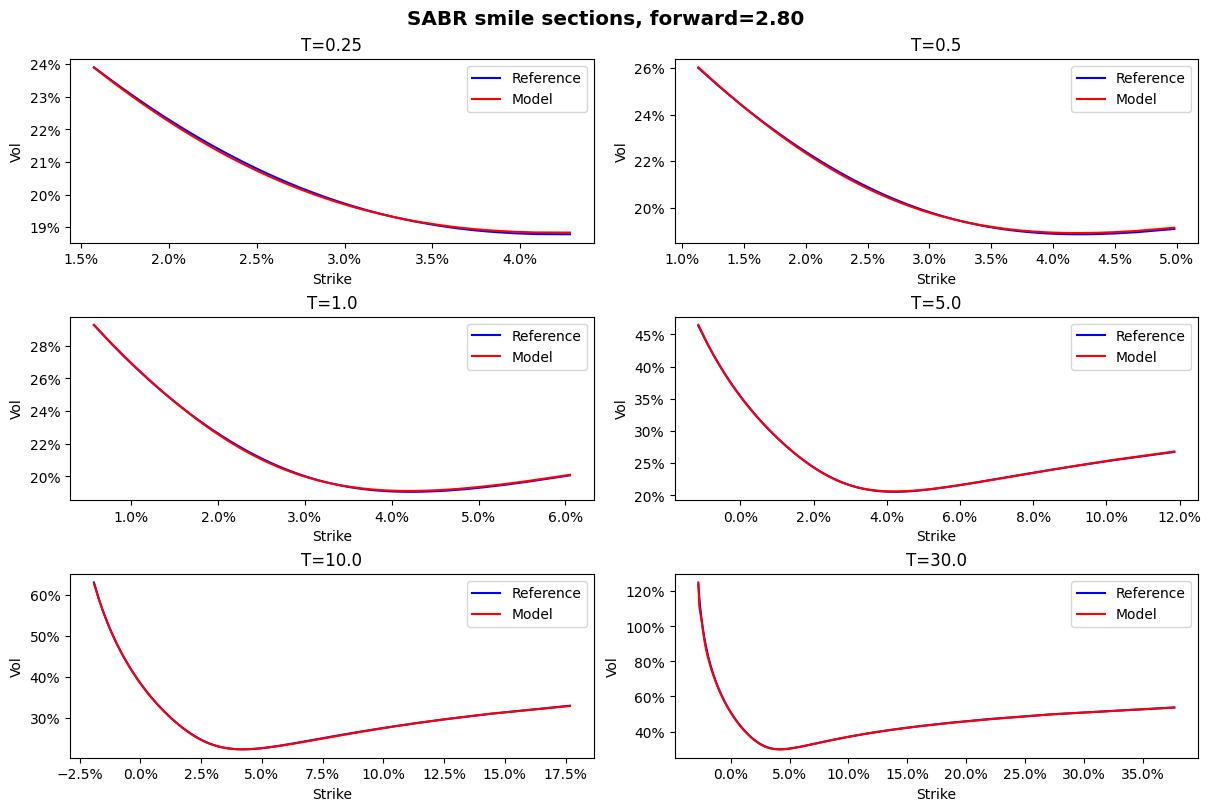

In [16]:
# Analyse results
print(">> Analyse results")

# Check performance
train_pred = model.predict(x_train)
train_rmse = bps_rmse(train_pred, y_train)
print(f"> RMSE(nvol) on training set: {train_rmse:,.2f}")

test_pred = model.predict(x_test)
test_rmse = bps_rmse(test_pred, y_test)
print(f"> RMSE(nvol) on test set: {test_rmse:,.2f}")

# Generate strike spread axis
print("> Choosing a sample parameter set to display chart")
NUM_STRIKES = 100
PARAMS = { 'LnVol': 0.20, 'Beta': 0.5, 'Nu': 0.55, 'Rho': -0.25, 'Gamma': 0.7, 'Kappa': 1.0,
            'Theta': 0.03, 'Xi': 0.35 }
FWD = 0.028

# Any number of expiries can be calculated, but for optimum display choose no more than 6
# EXPIRIES = np.asarray([0.125, 0.250, 0.5, 1.00, 2.0, 5.0]).reshape(-1, 1)
EXPIRIES = np.asarray([0.25, 0.50, 1.0, 5.00, 10.0, 30.0]).reshape(-1, 1)
NUM_EXPIRIES = EXPIRIES.shape[0]
METHOD = 'Percentiles'
PERCENTS = np.linspace(0.01, 0.99, num=NUM_STRIKES)
PERCENTS = np.asarray([PERCENTS] * NUM_EXPIRIES)

strikes = generator.convert_strikes(EXPIRIES, PERCENTS, FWD, PARAMS, METHOD)
ARE_CALLS = [[False] * NUM_STRIKES] * NUM_EXPIRIES # All puts

print("> Calculating chart surface with reference model")
timer_ref = Stopwatch("Reference surface calculation")
timer_ref.trigger()
ref_prices = generator.price_surface_ref(EXPIRIES, strikes, ARE_CALLS, FWD, PARAMS)
timer_ref.stop()

print("> Calculating chart surface with trained model")
timer_mod = Stopwatch("Model surface calculation")
timer_mod.trigger()
mod_prices = generator.price_surface_mod(model, EXPIRIES, strikes, ARE_CALLS, FWD, PARAMS)
timer_mod.stop()

print(f"> Ref-Mod RMSE(price): {bps_rmse(ref_prices, mod_prices):.2f}")

# Display timers
timer_ref.print()
timer_mod.print()

# Available tranforms: Price, ShiftedBlackScholes, Bachelier
TITLE = f"{MODEL_TYPE} smile sections, forward={FWD*100:.2f}"#,%\n parameters={PARAMS}"
# TRANSFORM = "Bachelier"
# TRANSFORM = "Price"
TRANSFORM = "ShiftedBlackScholes"
xplt.plot_transform_surface(EXPIRIES, strikes, ARE_CALLS, FWD, ref_prices, mod_prices,
                            TITLE, transform=TRANSFORM)

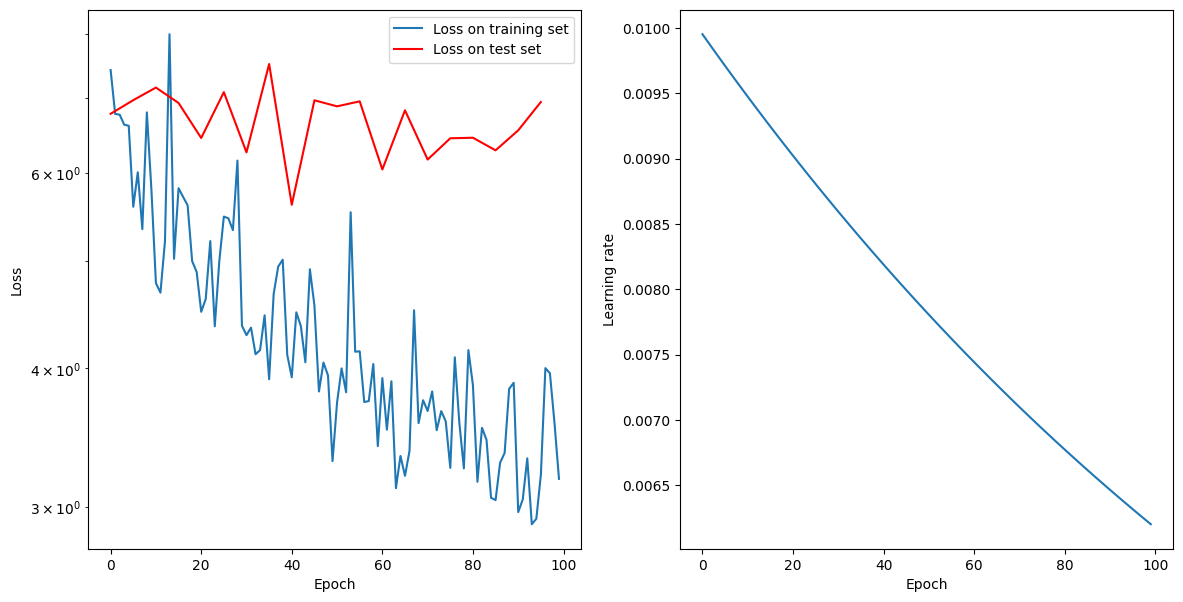

In [13]:
# Show training history
if TRAIN:
    hist_epochs = callback.epochs
    hist_losses = callback.losses
    hist_lr = callback.learning_rates
    sampled_epochs = callback.sampled_epochs
    test_losses = callback.test_losses

    plt.figure(figsize=(14, 7))
    plt.subplots_adjust(hspace=0.40)

    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale("log")
    plt.plot(hist_epochs, hist_losses, label='Loss on training set')
    plt.plot(sampled_epochs, test_losses, color='red', label='Loss on test set')
    plt.legend(loc='upper right')
    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Learning rate')
    plt.plot(hist_epochs, hist_lr)

    plt.show()